# Census Data

There are four variables inside the census dictionary

 - X (containing X[0] and X[1])
    - X[0] is the shape integral inputs (for big areas)
    - Y[0] are the number of people in each
    - X[1] is the location of house sales
    - X[1] is whether the house is small (a flat or terrace) or big (a semi-detached or detached house)
 - oaX are the shape integral inputs for tiny 'output areas'
 - oaY are the number of people in each
 - volumes = area (in km^2) of each training (X) area
 - oavolumes = area (in km^2) of each output area (oaX)

In [26]:
import pickle
import numpy as np
census_demo_data = pickle.load(open('census_demo_data.p','rb'))

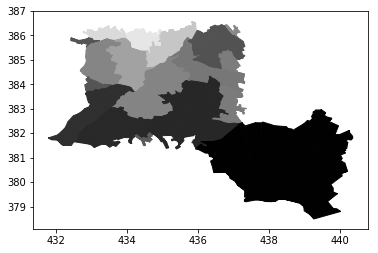

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
def plotsimplexes(X,col=None,lw=1):
    for c,x in zip(col,X):
        edges = []
        if x[-1]==0:
            for tri in x[0:-1].reshape(int(len(x)/6),6):
                plt.fill(tri[[0,2,4,0]],tri[[1,3,5,1]],c=c)
        else:
            plt.plot(x[0],x[1],'x'+c,mew=5,markersize=20)
            
#The combined Output areas
#the shades of grey refer to the population density
colours = (census_demo_data['Y'][0][:,0]/census_demo_data['volumes'])[:,None]
colours = 0.9*colours/np.max(colours)
colours = np.c_[colours,colours,colours]
plotsimplexes(census_demo_data['X'][0],colours)

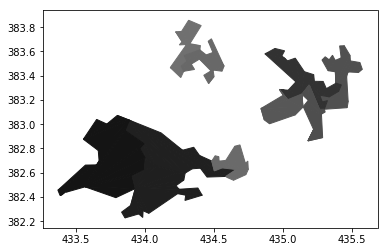

In [55]:
#The output areas
colours = (census_demo_data['oaY'][:,0]/census_demo_data['oavolumes'])[:,None]
colours = colours/(np.max(colours)/3)
colours[colours>0.9]=0.9
colours = np.c_[colours,colours,colours]
plotsimplexes(census_demo_data['oaX'][0:10,:],colours[0:10,:]) #just plotting first 10.

# Air Pollution Data

There are four variables inside the air pollution dictionary

 - X (containing X[0] and X[1])
    - X[0] is the intervals for the high-quality, low-frequency reference instrument (a turnkey osiris sensor https://turnkey-instruments.com/product/osiris/)
    - Y[0] are the PM2.5 SUMS (so this is the density, PM2.5 x time)
    - X[1] are the intervals for the low-quality, high-frequency cheap instrument (a pms5003 http://www.aqmd.gov/docs/default-source/aq-spec/resources-page/plantower-pms5003-manual_v2-3.pdf)
    - X[1] are the values (scaled by the intervals!)
    
I've had to scale the data in the plots - this is because the Ys are all densities (so the integrals can be used straight away with the integral kernel).

In [61]:
import pickle
import numpy as np
air_demo_data = pickle.load(open('air_pollution_demo_data.p','rb'))

No handles with labels found to put in legend.


(0.0, 72.0)

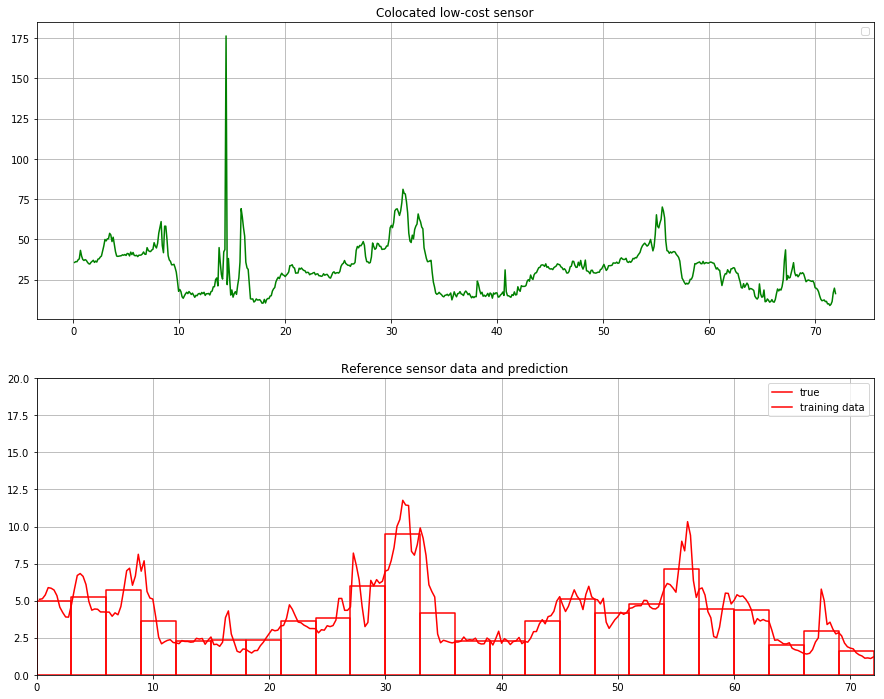

In [68]:
X = air_demo_data['X']
Y = air_demo_data['Y']
testX = air_demo_data['testX']
testY = air_demo_data['testY']
plt.figure(figsize=[15,12])
plt.subplot(2,1,1)
plt.plot(X[1][:,0],Y[1]/np.median(X[1][:,0]-X[1][:,1]),'g-')
plt.title('Colocated low-cost sensor')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.title('Reference sensor data and prediction')
#means,variances = model.predict(testX1)
#mean = means[0]
#var = variances[0]
#plt.plot(testX1[:,0],4*mean,'b-',label='prediction')
#plt.plot(testX1[:,0],4*mean+4*np.sqrt(var)*2,'b-',alpha=0.2)
#plt.plot(testX1[:,0],4*mean-4*np.sqrt(var)*2,'b-',alpha=0.2)
plt.plot(testX[:,0],testY,'r-',label='true') #test data red line

stepsize = X[0][1][0]-X[0][0][0]
lab = 'training data'
for x1,y1 in zip(X[0],Y[0]):
    #plt.plot([lr[0],lr[0]+stepsize,lr[0]+stepsize,lr[0],lr[0]],[0,0,lr[1],lr[1],0],'r-')
    plt.plot([x1[0],x1[0]-stepsize,x1[0]-stepsize,x1[0],x1[0]],[0,0,y1/3,y1/3,0],'r-',label=lab)
    lab = None
plt.legend()
plt.grid()
#plt.vlines(model.Z,0,1)
plt.ylim([0,20])
plt.xlim([X[0][0,1],X[0][-1,0]])